In [22]:
# dataset used can be found at https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# load the training dataset
train = pd.read_csv('datasets/train-data.csv')
train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
# Fetch the related info for the dataset used
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [4]:
pd.DataFrame(train.isna().sum())

,0
Unnamed: 0,0
Name,0
Location,0
Year,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,2
Engine,36


The `New_price` and `Unnamed` columns can be deleted as they either contains very large missing values or have no significance

**Cleaning Data**

In [5]:
# remove insignificant features
train.drop(['Unnamed: 0', 'New_Price'], axis=1, inplace=True)
train

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74
...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.4 kmpl,1248 CC,74 bhp,5.0,4.75
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.0,4.00
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,8.0,2.90
6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.0,2.65


The dataset contains two different metric system we can either convert them to same metric system or they are erroneous records which can be skipped. Judging from the data it seems like the records are errors and can be overlooked.

In [6]:
# list comprehension and regex
import re
index = [idx for idx, i in enumerate(train.Mileage) if re.search('km/kg', str(i))]
index

[0,
 5,
 127,
 328,
 440,
 839,
 893,
 936,
 987,
 1135,
 1218,
 1269,
 1323,
 1332,
 1357,
 1573,
 1780,
 1911,
 1914,
 2059,
 2110,
 2228,
 2278,
 2323,
 2371,
 2376,
 2385,
 2436,
 2437,
 2516,
 2527,
 2638,
 2701,
 2941,
 3008,
 3031,
 3097,
 3119,
 3129,
 3180,
 3295,
 3455,
 3511,
 3553,
 3586,
 3595,
 3722,
 3869,
 3901,
 4098,
 4141,
 4411,
 4603,
 4769,
 4920,
 5004,
 5178,
 5506,
 5655,
 5710,
 5747,
 5876,
 5881,
 5902,
 5935,
 5997]

In [7]:
train.drop(index, axis=0, inplace=True)
train

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.4 kmpl,1248 CC,74 bhp,5.0,4.75
6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.0,4.00
6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,8.0,2.90
6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.0,2.65


In [8]:
# converting column types using a customised function
def clean_data(df, col_name, **kwargs):
    kwargs = {'replace_values': dict(), 'dtype': float, **kwargs}
    keys = list(kwargs['replace_values'].keys())
    values = list(kwargs['replace_values'].values())
    df[col_name] = df[col_name].str.replace(keys[0], values[0]).replace(keys[1], values[1]).astype(kwargs['dtype'])
    kwargs = {'na_values':df[col_name].median(), **kwargs}
    df[col_name] = df[col_name].fillna(kwargs['na_values'])
    return df[col_name]
    
train['Mileage']=clean_data(train, col_name='Mileage', replace_values={' kmpl':'', 'null':0})
# train['Mileage'].str.replace(' kmpl','').replace('null',0)
train['Engine']=clean_data(train, col_name='Engine', replace_values={' CC':'', 'null':0})
# train['Engine'].str.replace(' CC','').replace('null',0)
train['Power']=clean_data(train, col_name='Power', replace_values={' bhp':'', 'null':0})
# train['Power'].str.replace(' bhp','').replace('null',0)
train['Seats']=train['Seats'].fillna(train['Seats'].median())

In [9]:
train = (train.reset_index()).drop('index', axis=1)
train

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
1,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
2,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
3,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
4,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...
5948,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.40,1248.0,74.00,5.0,4.75
5949,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.40,1120.0,71.00,5.0,4.00
5950,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.00,2498.0,112.00,8.0,2.90
5951,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.90,998.0,67.10,5.0,2.65


In [10]:
# Post cleansing
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5953 entries, 0 to 5952
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5953 non-null   object 
 1   Location           5953 non-null   object 
 2   Year               5953 non-null   int64  
 3   Kilometers_Driven  5953 non-null   int64  
 4   Fuel_Type          5953 non-null   object 
 5   Transmission       5953 non-null   object 
 6   Owner_Type         5953 non-null   object 
 7   Mileage            5953 non-null   float64
 8   Engine             5953 non-null   float64
 9   Power              5953 non-null   float64
 10  Seats              5953 non-null   float64
 11  Price              5953 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 558.2+ KB


In [63]:
visual_data=pd.DataFrame()
for i in range(train.shape[0]):
    visual_data.at[i, 'Company'] = train['Name'][i].split()[0].upper()
    visual_data.at[i, 'Mileage'] = float(str(train['Mileage'][i]).split()[0])
    visual_data.at[i, 'Engine'] = float(str(train['Engine'][i]).split()[0])
    visual_data.at[i, 'Power'] = float(str(train['Power'][i]).split()[0])
    visual_data.at[i, 'Price'] = float(str(train['Price'][i]).split()[0])
    visual_data.at[i, 'Location'] = train['Location'][i]
visual_data

,Company,Mileage,Engine,Power,Price,Location
0,HYUNDAI,19.67,1582.0,126.20,12.50,Pune
1,HONDA,18.20,1199.0,88.70,4.50,Chennai
2,MARUTI,20.77,1248.0,88.76,6.00,Chennai
3,AUDI,15.20,1968.0,140.80,17.74,Coimbatore
4,NISSAN,23.08,1461.0,63.10,3.50,Jaipur
...,...,...,...,...,...,...
5948,MARUTI,28.40,1248.0,74.00,4.75,Delhi
5949,HYUNDAI,24.40,1120.0,71.00,4.00,Jaipur
5950,MAHINDRA,14.00,2498.0,112.00,2.90,Jaipur
5951,MARUTI,18.90,998.0,67.10,2.65,Kolkata


**Visualization**

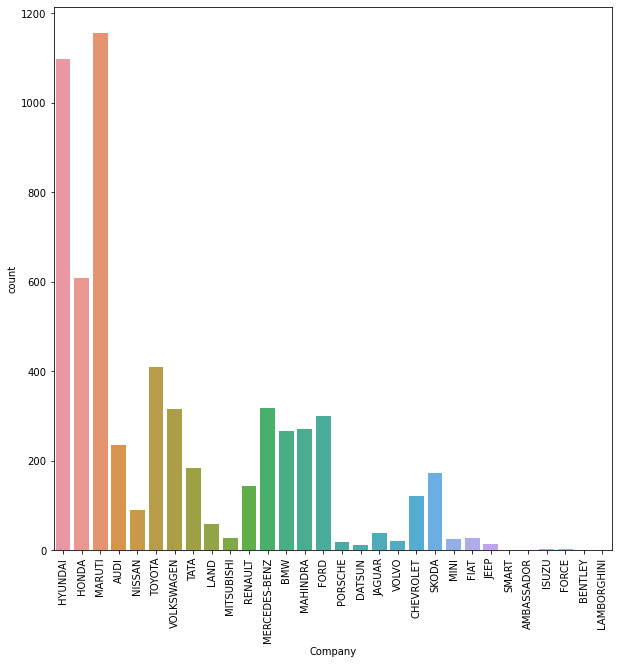

In [82]:
# Based on company
plt_data = visual_data['Company']
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,1,1)
ax = sns.countplot(x=plt_data.index, data=plt_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

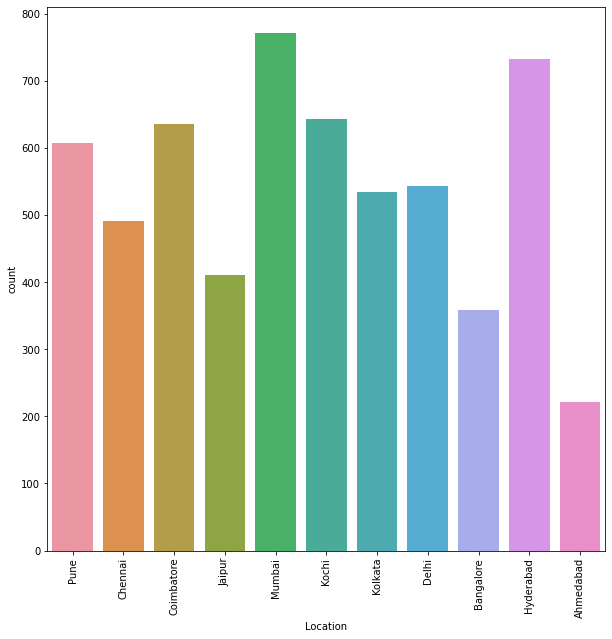

In [81]:
# Based on Location
plt_data = visual_data['Location']
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,1,1)
ax = sns.countplot(x=plt_data.index, data=plt_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()